Measure the Spin Qubit using RF via SHFQC device

Based upon `shfqa_qd_new_CS_20240429.ipynb` and https://github.com/zhinst/laboneq/blob/main/examples/03_superconducting_qubits/00_qubit_tuneup_shfsg_shfqa_shfqc.ipynb


In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
# LabOne Q:
#from laboneq.simple import *

from laboneq.dsl.experiment import (
    #Section,
    Experiment,
    ExperimentSignal,
    #Sweep,
    pulse_library
)
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.session import Session
from laboneq.dsl.calibration import (
    Calibration,
    SignalCalibration,
    Oscillator
)

from laboneq.dsl.enums import (
    AcquisitionType,
    AveragingMode,
    SectionAlignment,
    PortMode,
    ModulationType
)

from laboneq.dsl import LinearSweepParameter  # SweepParameter

from laboneq.pulse_sheet_viewer.pulse_sheet_viewer import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# plotting and fitting functionality
#from laboneq.analysis.fitting import (
    #lorentzian,
    #oscillatory,
    #oscillatory_decay,
#)

#from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_18864\3238781331.py:47: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Physical lines are the actual ports on the device. These are specified in the descriptor as our specific ports.

The logical lines can be any of the following. Multiple logical lines can correspond to the same physical line and their groups can be across different devices [reference](https://docs.zhinst.com/labone_q_user_manual/concepts/logical_signal_lines)
- **Drive** control lines to adjust qubits
- **Measure** line our RF measurement signal goes down
- **Acquire** response line from the measure line. Readout lines

Experiment signals are generic parameters defined for each experiment. Upon creation, they need to be mapped to logical signals. The reason for this distinction is so for superconducting qubits it is easy to change from q0 to q1 but in our case this is unnecessary


In [3]:
experiment = {
    "desc": "Test the RF code for sweeping the SET."
}

monty = Monty("rf.set testing", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 6


In [4]:
descriptor = """
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: set/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: p1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: p2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: j1/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: bt/drive_line  # bias tee
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: set/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: set/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""


In [5]:
def plot_sweeper(f, result, unwrap = True, deg = True, xlabel="Frequency (GHz)", ylabel="Power (dBm)", monty=None):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg else 'rad'
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    #ax0.legend(loc='upper left')
    ax0.set_ylabel(ylabel)
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    #ax1.legend(loc='upper left')
    ax1.set_xlabel(xlabel)
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    if monty is not None:
        ax0.set_title(monty.identifier + "." + monty.runname)
        monty.savefig(plt, "sweep")
    else:
        plt.show()

In [6]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# Create shortcuts to logical signals (LSG) for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}
# Use like lsg["set"]["drive_line"]

# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.06.20 16:05:19.744] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\LD2007\Documents\Si_CMOS_james\quench\june\laboneq_output\log
[2024.06.20 16:05:19.746] INFO    VERSION: laboneq 2.32.0
[2024.06.20 16:05:19.749] INFO    Connecting to data server at localhost:8004
[2024.06.20 16:05:19.823] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.06.20 16:05:19.871] WARNING SHFQC/QA:dev12158: Include the device options 'SHFQC/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.06.20 16:05:20.844] INFO    Configuring the device setup
[2024.06.20 16:05:20.952] INFO    The device setup is configured


In [7]:
# define device parameters

qubit_parameters = {
    #'ro_freq':  10e6,           # readout frequency of qubit 0 in [Hz] - relative to local oscillator for readout drive upconversion
    #'ro_amp': 0.5,              # readout amplitude
    #'ro_amp_spec': 0.05,         # readout amplitude for spectroscopy
    #'ro_len': 1.0e-6,           # readout pulse length in [s]
    #'ro_len_spec': 1.0e-6,      # readout pulse length for resonator spectroscopy in [s]
    #'ro_pulse_delay': 0e-9,     # readout delay after last drive signal in [s]
    #'ro_int_delay': 0e-9,     # readout line offset calibration - delay between readout pulse and start of signal acquisition in [s]
    #'ro_pout_range': -30,
    #"ro_pin_range": -5,

    # legacy from superconducting qubits
    #'qb_freq': 395.0e6,   # dr_df   # qubit 0 drive frequency in [Hz] - relative to local oscillator for qubit drive upconversion
    #'qb_amp_spec': 0.01,         # drive amplitude of qubit spectroscopy
    #'qb_len_spec': 15e-6,        # drive pulse length for qubit spectroscopy in [s]
    
    #'qb_len': 4e-7,             # qubit drive pulse length in [s]
    #'pi_amp': 0.5,              # qubit drive amplitude for pi pulse
    #'pi_half_amp': 0.25,        # qubit drive amplitude for pi/2 pulse
    #'qb_t1': 100e-6,            # qubit T1 time
    #'qb_t2': 100e-6,            # qubit T2 time
    #'relax': 200e-6,             # delay time after each measurement for qubit reset in [s]

    # up / downconversion settings - to convert between IF and RF frequencies

    #'qb_lo': 4.0e9,              # qubit LO frequency in [Hz]
    'ro_lo': 1.0e9,   # (ro_cent_f)   # readout LO frequency in [Hz]
    #'dr_lo': 7.0e9,   # (dr_cent_f)  # drive LO frequency [Hz]
}

## frequency sweep impendence network

In [95]:
def compile_run(session, exp_params, exp):
    compiler_settings = {
        "OUTPUT_EXTRAS": True,
        "MAX_EVENTS_TO_PUBLISH": 1000,
    }
    compiled_exp = session.compile(exp, compiler_settings=compiler_settings)
    results = session.run(compiled_exp)
    root = Path("/Users/LD2007/Documents/Si_CMOS_james/pulse_sheets")
    root.mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(root.joinpath(f"{exp_params["exp_name"]}"), compiled_exp)
    #if exp_params["plot_simulation"] == 1:
    #plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])
    return results

In [9]:
def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid="spectroscopy",
        signals=[
            ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
            ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
        ],
    )
    # define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.CYCLIC,  # SEQUENTIAL?
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
            # readout pulse and data acquisition
            with exp.section(uid="spectroscopy"):
                # resonator signal readout
                exp.acquire(
                    signal="acquire",
                    handle=exp_params["exp_name"],
                    length=exp_params["integration_time"],
                )
            # relax time after readout - for qubit relaxation to groundstate and signal processing
            with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                exp.reserve(signal="measure")
                exp.reserve(signal="acquire")
                    
    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=exp_params["ro_osc_gain"],
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_lo"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results

Started new run spectroscopy
[2024.06.20 13:43:56.425] INFO    Starting LabOne Q Compiler run...
[2024.06.20 13:43:56.517] INFO    Schedule completed. [0.090 s]
[2024.06.20 13:43:56.722] INFO    Code generation completed for all AWGs. [0.205 s]
[2024.06.20 13:43:56.723] INFO    Completed compilation step 1 of 1. [0.296 s]
[2024.06.20 13:43:56.730] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.20 13:43:56.731] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.20 13:43:56.732] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.20 13:43:56.733] INFO      device_shfqc     0         21            0           0         0  
[2024.06.20 13:43:56.733] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.20 13:43:56.734] INFO      TOTAL                      21            0                     0  
[2024.06.20 13:43:56.735] INFO     ───────────────────────

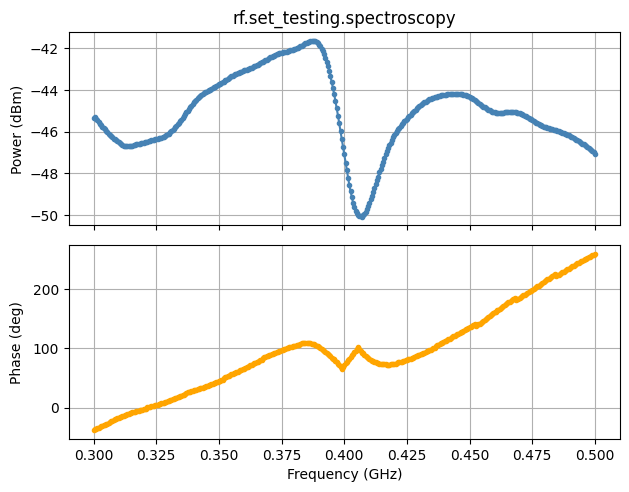

In [11]:
start_freq = 300.0e6
stop_freq = 500.0e6
num_points = 401

freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

exp_params_spec = qubit_parameters.copy()
exp_params_spec.update({
    "exp_name": "cw",
    "wait_after_int": 7e-6,
    "integration_time": 2e-6,
    "ro_osc_gain": 0.5,
    #"plot_simulation": 0,
    "num_averages": 10,
    "freq_sweep": freq_sweep,
    

    # overwrite above
    "ro_lo": 1.0e9,
    "ro_pout_range": -10,
    "ro_pin_range": -5
})

monty.newrun("spectroscopy", exp_params_spec)
results_cw_res = res_spectroscopy(session, exp_params_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_spec["exp_name"]].axis))
data = results_cw_res.acquired_results[exp_params_spec["exp_name"]].data
monty.save({"data": data})
plot_sweeper(f, data, monty=monty)

In [12]:
# rough approximation of the optimal frequency
f[np.argmin(np.abs(data))]

array([4.07e+08])

## SET gate (coulomb blocking) sweep

In [10]:
# create the experiment
def spectroscopy(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]):
            with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                with exp.section(uid = "g1_1"):
                    exp.play(signal = "drive_set",
                             pulse = exp_params["dr_pulse"],
                             amplitude = exp_params["dr_amp_sweep"],
                             phase = 180)  # note that the phase does not affect the output amplitude 

                with exp.section(uid="readout"):
                    exp.measure(
                        acquire_signal ="acquire",
                        handle = "results",
                        integration_length=exp_params["integration_time"],
                        reset_delay=exp_params["wait_after_int"],
                    )
                    

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    cal["measure"] = SignalCalibration(
        #local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        #oscillator=Oscillator(frequency=exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

Started new run rf_ST_sweep.7
[2024.06.22 23:52:31.210] INFO    Resolved modulation type of oscillator 'osc_362' on signal 'acquire' to HARDWARE
[2024.06.22 23:52:31.211] INFO    Resolved modulation type of oscillator 'osc_360' on signal 'drive_set' to HARDWARE
[2024.06.22 23:52:31.212] INFO    Starting LabOne Q Compiler run...
[2024.06.22 23:52:31.330] INFO    Schedule completed. [0.115 s]
[2024.06.22 23:52:42.480] INFO    Code generation completed for all AWGs. [11.150 s]
[2024.06.22 23:52:42.482] INFO    Completed compilation step 1 of 1. [11.267 s]
[2024.06.22 23:52:42.486] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.22 23:52:42.487] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.22 23:52:42.488] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.22 23:52:42.488] INFO      device_shfqc        0         12            0           0         0  
[2024.06.22 23:52

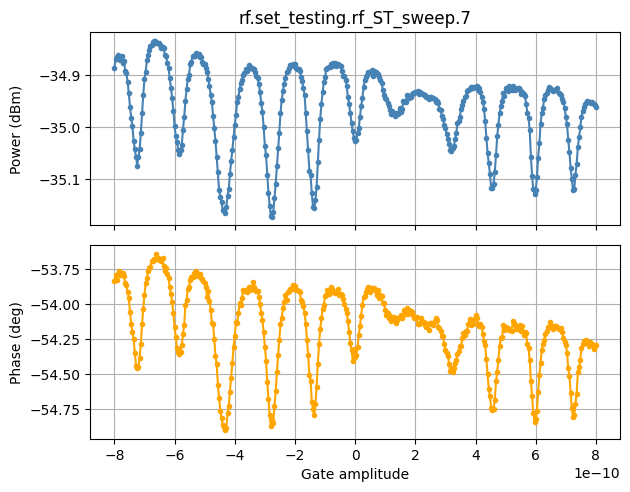

In [147]:
# define pulses

dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.8, stop = 0.8, count=401)

exp_set_sweep = qubit_parameters.copy()
exp_set_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 100e-6,
    "ro_osc_gain": 0.5,

    "set_freq": 406.6e6,
    "num_averages": 8,
    "dr_pout_range": 5,
    "ro_pout_range": -20,
    "ro_pin_range": -10,

    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
})

monty.newrun("rf ST sweep", exp_set_sweep)
results = spectroscopy(session, exp_set_sweep)

data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

## frequency sweep over SET range

In [107]:
# create the experiment
def freqset(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid="sweep freq", parameter=exp_params["freq_sweep"]):
            with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]):
                with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                    with exp.section(uid = "g1_1"):
                        exp.play(signal = "drive_set",
                                 pulse = exp_params["dr_pulse"],
                                 amplitude = exp_params["dr_amp_sweep"],
                                 phase = 180)  # note that the phase does not affect the output amplitude 
    
                    with exp.section(uid="readout"):
                        exp.measure(
                            acquire_signal = "acquire",
                            handle = "results",
                            integration_length=exp_params["integration_time"],
                            reset_delay=exp_params["wait_after_int"]
                        )

                        # resonator signal readout
                        #exp.acquire(
                        #    signal="acquire",
                        #    handle="results",
                        #    length=exp_params["integration_time"],
                        #)
                    # relax time after readout - for qubit relaxation to groundstate and signal processing
                    #with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                    #    exp.reserve(signal="measure")
                    #    exp.reserve(signal="acquire")
                        #exp.reserve(signal="drive_set")

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        #oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    # CW output for measurement
    cal["measure"] = SignalCalibration(
        #local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

Run finished and took 0:00:11.780312.
Started new run rf_ST_freq_sweep.23
[2024.06.22 23:10:01.166] INFO    Resolved modulation type of oscillator 'osc_335' on signal 'drive_set' to HARDWARE
[2024.06.22 23:10:01.167] INFO    Starting LabOne Q Compiler run...
[2024.06.22 23:10:02.172] INFO    Schedule completed. [1.003 s]
[2024.06.22 23:10:36.454] INFO    Code generation completed for all AWGs. [34.282 s]
[2024.06.22 23:10:36.457] INFO    Completed compilation step 1 of 1. [35.288 s]
[2024.06.22 23:10:36.463] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.22 23:10:36.468] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.22 23:10:36.469] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.22 23:10:36.472] INFO      device_shfqc        0         12            0           0         0  
[2024.06.22 23:10:36.474] INFO      device_shfqc_sg     0        620          202       

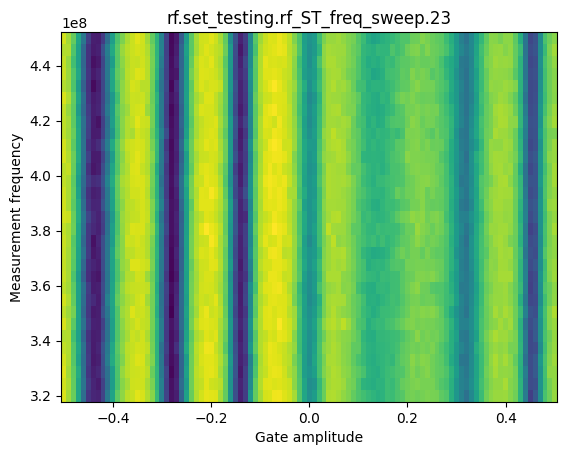

In [108]:
# similar setup to above, but vary the set_freq over a range

start_freq = 320.0e6
stop_freq = 450.0e6
num_points = 31

# frequencies to sweep over
freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

# define the gate DC pulses
dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.5, stop = 0.5, count=101)

exp_set_freq_sweep = qubit_parameters.copy()
exp_set_freq_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 100e-6,
    "ro_osc_gain": 0.5,
    
    "num_averages": 8,
    "dr_pout_range": 5,
    "ro_pout_range": -20,
    "ro_pin_range": 0,

    "freq_sweep": freq_sweep,  # frequencies to sweep over
    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
})

monty.newrun("rf ST freq sweep", exp_set_freq_sweep)
results = freqset(session, exp_set_freq_sweep)
data = results.acquired_results["results"].data
monty.save({"data": data})
#plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values, np.abs(data), shading="nearest")
plt.xlabel("Gate amplitude")
plt.ylabel("Measurement frequency")
plt.title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "2d")

In [103]:
results.acquired_results["results"].data

array([[0.00259579+0.00222291j, 0.00259631+0.00223029j,
        0.00259728+0.00222571j, ..., 0.00261199+0.00219227j,
        0.0026112 +0.00219229j, 0.00261156+0.00219578j],
       [0.00259787+0.00222217j, 0.0025972 +0.00222529j,
        0.00259864+0.002222j  , ..., 0.00260979+0.00219388j,
        0.00261133+0.00219368j, 0.00261047+0.00219497j],
       [0.0025972 +0.00222279j, 0.0025974 +0.00222441j,
        0.00259474+0.0022218j , ..., 0.00261275+0.00219431j,
        0.00261031+0.00219652j, 0.00261256+0.00219744j],
       ...,
       [0.00259666+0.00222277j, 0.00259805+0.00222584j,
        0.00259842+0.00222002j, ..., 0.00260875+0.00219125j,
        0.00261088+0.0021972j , 0.00260724+0.00219791j],
       [0.00259534+0.00222205j, 0.00259612+0.00222498j,
        0.00259601+0.00222121j, ..., 0.00261037+0.0021948j ,
        0.00261112+0.00219565j, 0.00260709+0.00219672j],
       [0.0025971 +0.00222307j, 0.00259558+0.0022224j ,
        0.00259711+0.00221888j, ..., 0.00261015+0.00219634j,
 

above code doesn't actually work. The frequencies aren't really being swept over. I think we should be using `exp.acquire` instead of `exp.measure` when getting the data as `exp.acquire` doesn't send a measurement pulse. This is important for continuous wave measurements

In [148]:
# create the experiment
def freqset2(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid="sweep freq", parameter=exp_params["freq_sweep"]):
            with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]):
                with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                    with exp.section(uid = "g1_1"):
                        exp.play(signal = "drive_set",
                                 pulse = exp_params["dr_pulse"],
                                 amplitude = exp_params["dr_amp_sweep"],
                                 phase = 180)  # note that the phase does not affect the output amplitude 
    
                    with exp.section(uid="readout"):
                        exp.acquire(
                            signal="acquire",
                            handle="results",
                            length=exp_params["integration_time"],
                        )
                    # relax time after readout - for qubit relaxation to groundstate and signal processing
                    with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                        exp.reserve(signal="measure")
                        exp.reserve(signal="acquire")
                        exp.reserve(signal="drive_set")

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        #oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    # CW output for measurement
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        #local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

Started new run 2ST_freq_sweep.5
[2024.06.23 00:11:10.009] INFO    Resolved modulation type of oscillator 'osc_369' on signal 'drive_set' to HARDWARE
[2024.06.23 00:11:10.010] INFO    Starting LabOne Q Compiler run...
[2024.06.23 00:11:16.966] INFO    Schedule completed. [6.954 s]
[2024.06.23 00:12:57.670] INFO    Code generation completed for all AWGs. [100.703 s]
[2024.06.23 00:12:57.672] INFO    Completed compilation step 1 of 1. [107.659 s]
[2024.06.23 00:12:57.676] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.23 00:12:57.677] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.23 00:12:57.678] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.23 00:12:57.679] INFO      device_shfqc        0       2129            0           0         0  
[2024.06.23 00:12:57.680] INFO      device_shfqc_sg     0       2119          602           2       128  
[2024.06.23 00:12:57.

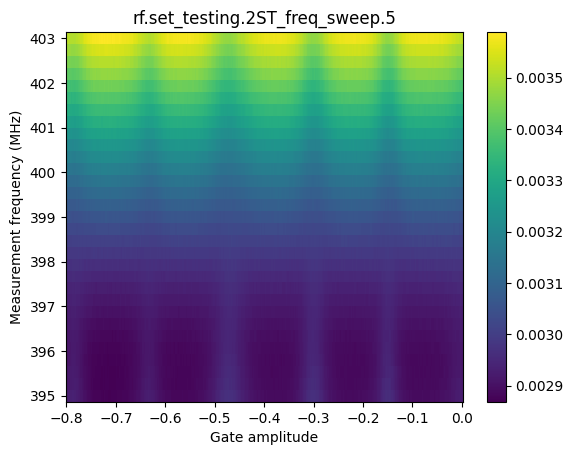

In [152]:
# better version of above

start_freq = 395.0e6
stop_freq = 403.0e6
num_points = 31

# frequencies to sweep over
freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

# define the gate DC pulses
dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.8, stop = 0.0, count=301)

exp_set_freq_sweep = qubit_parameters.copy()
exp_set_freq_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 100e-6,
    "ro_osc_gain": 0.5,
    
    "num_averages": 8,
    "dr_pout_range": 5,
    "ro_pout_range": -20,
    "ro_pin_range": 0,

    "freq_sweep": freq_sweep,  # frequencies to sweep over
    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep

    "ro_lo": 1e9,
})

monty.newrun("2ST freq sweep", exp_set_freq_sweep)
results = freqset2(session, exp_set_freq_sweep)
data = results.acquired_results["results"].data
monty.save({"data": data})


plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values/1e6, np.abs(data), shading="nearest")
plt.colorbar()
plt.xlabel("Gate amplitude")
plt.ylabel("Measurement frequency (MHz)")
plt.title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "2d")

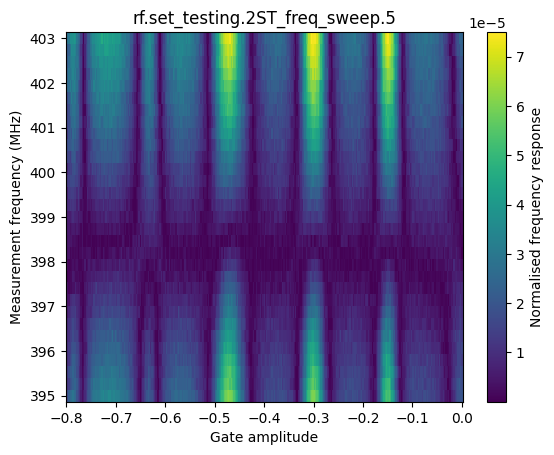

In [153]:
# normalise the frequency to their average value
d = np.abs(data.copy())
d -= np.repeat((np.sum(d, axis=1)/d.shape[1])[:, np.newaxis], d.shape[1], axis=1)
plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values/1e6, np.abs(d), shading="nearest")
cb = plt.colorbar()
cb.ax.set_ylabel("Normalised frequency response")
plt.xlabel("Gate amplitude")
plt.ylabel("Measurement frequency (MHz)")
plt.title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "normalised response")

array([-0.85319411-0.3573727j, -0.85319411-0.3573727j])

In [ ]:
# plot the frequency derivative
d = data.copy()
plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values[1:], np.abs(np.diff(d, axis=0)), shading="nearest")
plt.colorbar()

In [ ]:
# normalise each t

## Power sweep

In [68]:
# measure the SET drives over different powers

# define pulses

pwrs = [-30, -25, -20, -15, -10, -5, 0, 5]

dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.5, stop = 0.5, count=401)

data = {}

for pwr in tqdm(pwrs):
    exp_pwr_sweep = qubit_parameters.copy()
    exp_pwr_sweep.update({
        "exp_name": "sweep",
        "wait_after_int": 10e-6,
        "integration_time": 100e-6,
        "ro_osc_gain": 0.5,
    
        "set_freq": 406.6e6,
        "num_averages": 8,
        "dr_pout_range": 5,
        "ro_pout_range": pwr,
        "ro_pin_range": pwr,
    
        "dr_pulse": dr_pulse,  # drive pulse
        "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
    })
    
    monty.newrun("pwr set sweep", exp_pwr_sweep)
    results = spectroscopy(session, exp_pwr_sweep)
    
    data[str(pwr)] = results.acquired_results["results"].data
monty.save({"data": data})

#plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

  0%|          | 0/8 [00:00<?, ?it/s]

Run finished and took 0:00:37.846016.
Started new run pwr_set_sweep.8
[2024.06.21 16:23:59.351] INFO    Resolved modulation type of oscillator 'osc_233' on signal 'acquire' to HARDWARE
[2024.06.21 16:23:59.352] INFO    Resolved modulation type of oscillator 'osc_231' on signal 'drive_set' to HARDWARE
[2024.06.21 16:23:59.354] INFO    Starting LabOne Q Compiler run...
[2024.06.21 16:23:59.463] INFO    Schedule completed. [0.107 s]
[2024.06.21 16:24:10.346] INFO    Code generation completed for all AWGs. [10.881 s]
[2024.06.21 16:24:10.347] INFO    Completed compilation step 1 of 1. [10.990 s]
[2024.06.21 16:24:10.351] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.21 16:24:10.352] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.21 16:24:10.353] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.21 16:24:10.354] INFO      device_shfqc        0         12            0  

Text(0.5, 1.0, 'rf.set_testing.pwr_set_sweep.15')

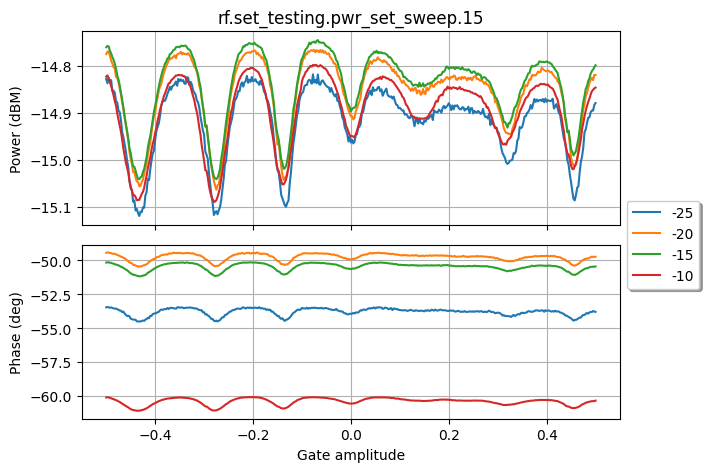

In [77]:
def topower(res, unwrap=True, deg=True):
    power = 10*np.log10(np.abs(res)**2/50*1000)
    phase = np.unwrap(np.angle(res, deg = deg)) if unwrap is True else np.angle(res, deg = deg)
    #phase_unit = 'deg' if deg else 'rad'
    return power, phase


X = dr_amp_sweep.values

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

for pwr in pwrs[1:-3]:

    power, phase = topower(data[str(pwr)])
    power -= pwr
    ax0.plot(X, power, '-', label = 'power')
    ax1.plot(X, phase, '-', label = str(pwr))


#ax0.legend(loc='upper left')
ax0.set_ylabel("Power (dBM)")
#ax1.legend(loc='upper left')
ax1.set_xlabel("Gate amplitude")
fig.align_ylabels([ax0, ax1])
ax0.grid()
ax1.grid()
ax1.set_ylabel("Phase (deg)")
plt.tight_layout()

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=True, ncol=1)
               
ax0.set_title(monty.identifier + "." + monty.runname)
#monty.savefig(plt, "sweep")

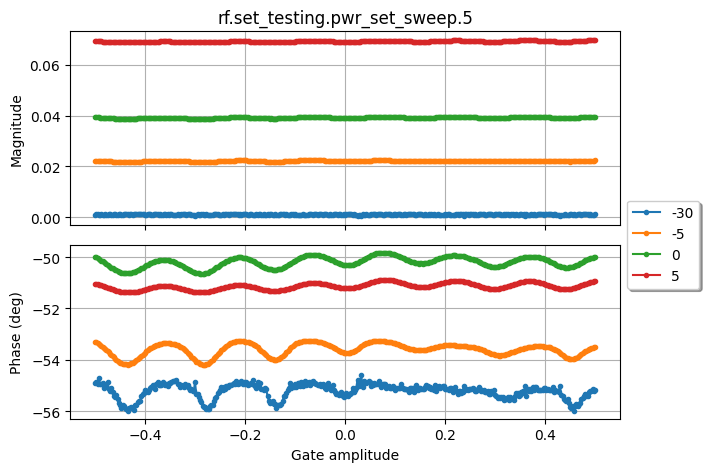

In [66]:
X = dr_amp_sweep.values

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

for pwr in pwrs:

    d = data[str(pwr)]
    power = np.abs(d)
    phase = np.unwrap(np.angle(d, deg = True))
    
    ax0.plot(X, power, '.-', label = 'power')
    ax1.plot(X, phase, '.-', label = str(pwr))


#ax0.legend(loc='upper left')
ax0.set_ylabel("Magnitude")
#ax1.legend(loc='upper left')
ax1.set_xlabel("Gate amplitude")
fig.align_ylabels([ax0, ax1])
ax0.grid()
ax1.grid()
ax1.set_ylabel("Phase (deg)")
plt.tight_layout()

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 1.0),
          fancybox=True, shadow=True, ncol=1)
               
ax0.set_title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "sweep")

# Other sweeps (unfinished)

In [14]:
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=401)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
            ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), # add additional drive lines for P1, P2, etc
            ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
            ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**3,
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep set', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                # note that the phase does not affect the output amplitude 
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=50e-6,
                            reset_delay=1000e-6)
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=395.0e6),
    # port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data

[2024.06.19 10:53:44.602] INFO    Resolved modulation type of oscillator 'osc_9' on signal 'acquire' to HARDWARE
[2024.06.19 10:53:44.603] INFO    Resolved modulation type of oscillator 'osc_7' on signal 'drive_set' to HARDWARE
[2024.06.19 10:53:44.604] INFO    Starting LabOne Q Compiler run...
[2024.06.19 10:53:44.672] INFO    Schedule completed. [0.065 s]
[2024.06.19 10:53:54.398] INFO    Code generation completed for all AWGs. [9.724 s]
[2024.06.19 10:53:54.399] INFO    Completed compilation step 1 of 1. [9.792 s]
[2024.06.19 10:53:54.404] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.19 10:53:54.405] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.19 10:53:54.406] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.19 10:53:54.407] INFO      device_shfqc        0         13            0           0         0  
[2024.06.19 10:53:54.408] INFO      device_shfqc_sg  

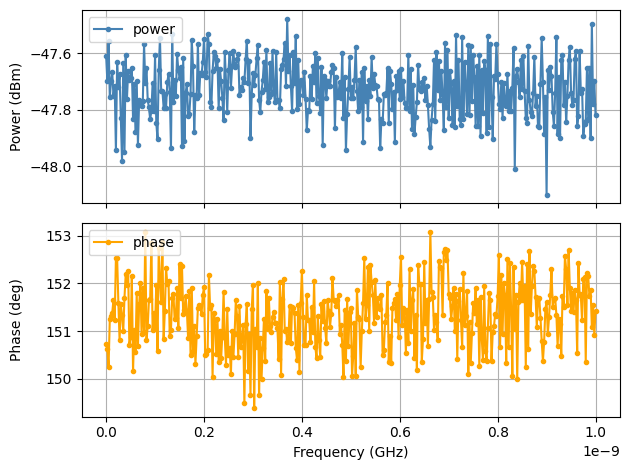

In [15]:
plot_sweeper(amp_sweep_g1, data)

## P1 sweep

In [16]:
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=11)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), 
        ExperimentSignal("drive_bt", map_to=lsg["bt"]["drive_line"]),
        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**3,
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep p1', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                # note that the phase does not affect the output amplitude 
                exp.play(signal="drive_p1", pulse=g2_pulse, amplitude = amp_sweep_g1, phase = 180)
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=50e-6,
                            reset_delay=1000e-6)
                
                
    # Where do we add feedback? There are no "loops" for us to add it in currently...
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_bt"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_p1"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=395.0e6),
    # port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data

[2024.06.19 10:54:10.018] INFO    Resolved modulation type of oscillator 'osc_17' on signal 'acquire' to HARDWARE
[2024.06.19 10:54:10.019] INFO    Resolved modulation type of oscillator 'osc_13' on signal 'drive_bt' to HARDWARE
[2024.06.19 10:54:10.019] INFO    Resolved modulation type of oscillator 'osc_15' on signal 'drive_p1' to HARDWARE
[2024.06.19 10:54:10.021] INFO    Resolved modulation type of oscillator 'osc_11' on signal 'drive_set' to HARDWARE
[2024.06.19 10:54:10.022] INFO    Starting LabOne Q Compiler run...
[2024.06.19 10:54:10.032] INFO    Schedule completed. [0.006 s]
[2024.06.19 10:54:10.401] INFO    Code generation completed for all AWGs. [0.369 s]
[2024.06.19 10:54:10.403] INFO    Completed compilation step 1 of 1. [0.378 s]
[2024.06.19 10:54:10.409] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.19 10:54:10.410] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.19 10:54:10.411] INFO   

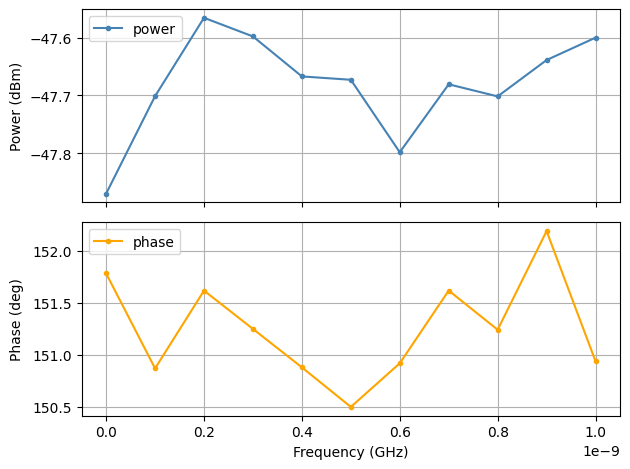

In [17]:
plot_sweeper(amp_sweep_g1, data)
